## Q learning formule de Bellman

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Initialisation de l'environnement (grille)
grid_size = 10
env = np.zeros((grid_size, grid_size))  # Grille vide
goal = (9, 9)

# Ajout d'obstacles
obstacles = [(0, 5), (0, 6), (3, 3), (3, 4), (6, 5), (6, 6)]
for obs in obstacles:
    env[obs] = 1
env[goal] = 10 # But

# Afficher la grille
env

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]])

In [3]:
# Initialisation des paramètres
actions = ['H', 'B', 'G', 'D']  # Haut, Bas, Gauche, Droite
#q_table = np.zeros((grid_size, grid_size))  # Q-valeurs
q_table = np.zeros((grid_size, grid_size, len(actions))) 
alpha = 0.1  # Taux d'apprentissage
gamma = 0.9  # Taux de discount
epsilon = 0.1  # Exploration/exploitation
q_table.shape

(10, 10, 4)

In [20]:
# Définir les récompenses
def get_reward(state):
    x, y = state
    if env[x, y] == 1:  # Obstacle
        return -10
    elif (x, y) == (9, 9):  # Objectif
        return 10 
    else:
        return 1 / (abs(x - goal[0]) + abs(y - goal[1]) )

# Déplacer le robot
def take_action(state, action):
    x, y = state
    
    # Restriction pour la position (0, 0)
    if state == (0, 0):
        if action == 'B':  # Bas
            x += 1
        elif action == 'D':  # Droite
            y += 1
        # Les autres actions ne sont pas permises, rester dans l'état actuel
        return (x, y)
    
    
    if action == 'H' and x > 0:
        x -= 1
    elif action == 'B' and x < grid_size - 1:
        x += 1
    elif action == 'G' and y > 0:
        y -= 1
    elif action == 'D' and y < grid_size - 1:
        y += 1
    return (x, y)

# Q-learning
episodes = 100
for episode in range(episodes):
    state = (0, 0)
    while state != (9, 9):
        # Choisir une action
        if np.random.uniform(0, 1) < epsilon:
            action_index = np.random.choice(len(actions))  # Exploration
        else:
            action_index = np.argmax(q_table[state[0], state[1], :])  # Exploitation
        
        action = actions[action_index]
        next_state = take_action(state, action)
        reward = get_reward(next_state)
        
        # Mettre à jour la Q-valeur
        q_table[state[0], state[1], action_index] += alpha * (
            reward + gamma * np.max(q_table[next_state[0], next_state[1], :]) - 
            q_table[state[0], state[1], action_index]
        )
        
        state = next_state


In [13]:
# Trouver un chemin valide
valid_path = []
state = (0, 0)

while state != (9, 9):
    valid_path.append(state)
    action_index = np.argmax(q_table[state[0], state[1], :])
    action = actions[action_index]
    next_state = take_action(state, action)
    
    # Vérifiez si l'état suivant est valide (pas un obstacle)
    if env[next_state[0], next_state[1]] == 1:
        print("Erreur : chemin passe par un obstacle !")
        break
    state = next_state

valid_path.append((9, 9))  # Ajouter l'objectif
print("Chemin valide :", valid_path)


Chemin valide : [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (3, 5), (3, 6), (2, 6), (2, 7), (1, 7), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]


In [21]:
def visualize_path(env, path):
    grid_size = env.shape[0]
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Dessiner les cases
    for x in range(grid_size):
        for y in range(grid_size):
            if env[x, y] == 1:  # Obstacle
                rect = patches.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
            else:  # Case valide
                rect = patches.Rectangle((y, grid_size - x - 1), 1, 1, edgecolor='gray', facecolor='white')
            ax.add_patch(rect)
    
    # Dessiner le chemin
    for i in range(len(path) - 1):
        start = path[i]
        end = path[i + 1]
        # Matplotlib dessine en coordonnées inversées (x devient y et y devient x)
        ax.plot(
            [start[1] + 0.5, end[1] + 0.5], 
            [grid_size - start[0] - 0.5, grid_size - end[0] - 0.5], 
            color='blue', linewidth=2
        )
    
    # Marquer le point de départ et l'objectif
    start = path[0]
    goal = path[-1]
    ax.plot(start[1] + 0.5, grid_size - start[0] - 0.5, 'go', markersize=10, label="Départ")  # Vert
    ax.plot(goal[1] + 0.5, grid_size - goal[0] - 0.5, 'ro', markersize=10, label="Objectif")  # Rouge
    
    # Configurer les axes
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size-1,0,-1))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    plt.title("Chemin valide dans la grille")
    plt.show()


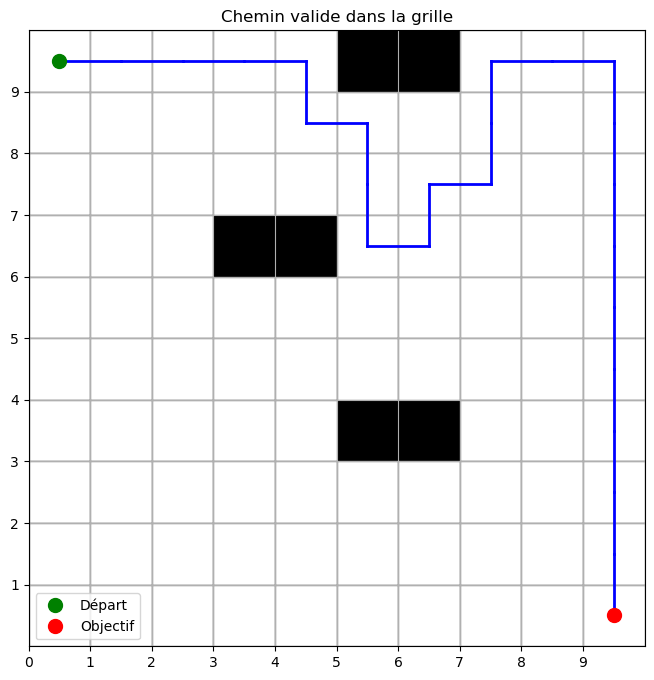

In [22]:
visualize_path(env, valid_path)

## Greedy Q learning (cours)

In [10]:
Q = np.zeros((grid_size, grid_size, len(actions))) 

In [ ]:
# Définir les récompenses
def get_reward2(state):
    x, y = state
    if env[x, y] == 1:  # Obstacle
        return -10
    elif (x, y) == (9, 9):  # Objectif
        return 10
    else:
        return 1 / (abs(x - goal[0]) + abs(y - goal[1]) )

# Q-learning
def train_q_algorithm(episodes, Q):
    for episode in range(episodes):
        state = (0, 0)
        while state != (9, 9):
            # Choisir une action
            action_index = np.argmax(Q[state[0], state[1], :])  # Exploitation
            
            action = actions[action_index]
            next_state = take_action(state, action)
            reward = get_reward2(next_state)
            
            # Mettre à jour la Q-valeur
            Q[state[0], state[1], action_index] += reward + gamma * np.max(Q[next_state[0], next_state[1], :])
            print("La state est ",state)
            print("l'entrainement est dans la state de ",Q[state[0], state[1], :])
            
            state = next_state
    return Q
episodes = 10
Q = train_q_algorithm(episodes, Q)
